In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
%matplotlib inline



Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/hrishi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Logic Based FizzBuzz Function [Software 1.0]

In [2]:
def fizzbuzz(n):
    
    # Logic Explanation
    # Here, the input number n is checked if it is divisible by 3 or 5 or both. 
    # If the input number n is divisible by 3, 'Fizz' is returned. 
    # Or else, if input number n is divisible by 5, then 'Buzz' is returned. 
    # Or, if the input number is divisible by both then 'FizzBuzz' is returned.
    
    
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [3]:
def createInputCSV(start,end,filename):
    
    # Why list in Python?
    # In python, List is a Data Structure which is ordered and changeable. It is a collection of arbitrary objects. Lists make it easier to read and store any data. 
    # In this context, lists are used to store the input numbers and output values which are huge in number, since it is not practical to input all numbers and write 
    # all the output values to the output file one by one. In short, inputData reads all numbers from files and after processing, outputData stores all the values.
    inputData   = []
    outputData  = []
    
    # Why do we need training Data?
    # In machine learning, training on testing data is considered illegal. Testing data is used to test the function on a small amount of data. Training data is used to 
    # train the model using huge amounts of data necessry for the algorithm. In short, training data is used to help a machine learn using large amounts of relevant 
    # information since training data is enriched information and large amount of training data is needed to increase accuracy.
    
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Why Dataframe?
    # Dataframes are a way to store data in rectangular grids that can be overviewed easily. Each row coresponds to an input of data of an instance and each column is vector 
    # corresponding to a value for a specific variable. Hence dataframes are used to store the input values i.e numbers and also store the fizzbuzz equivalent of it.
       
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [4]:
def processData(dataset):
    
    # Why do we have to process?
    # Data processing converts given data into a more useful and informative format which can be processed easily and efficiently. Since datasets can be raw information which may not
    # be understood by the computer, processing makes it efficient by converting it to easily readable and processable format.    
    
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [5]:
import numpy as np

def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10?
        # Here we are converting an input number to its binary format using the bitwise right shift operator(>>) where number ranges from 0 to 9, since range(n) in python 
        # denotes a set of values from 0 to n-1. So we are using the number 10 to convert all the numbers from 0 to 9 to their binary equivalent.
        
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [6]:
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

In [7]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


In [8]:
# Read Dataset
trainingData = pd.read_csv('training.csv')
testingData  = pd.read_csv('testing.csv')

# Process Dataset
processedTrainingData, processedTrainingLabel = processData(trainingData)
processedTestingData, processedTestingLabel   = processData(testingData)

## Tensorflow Model Definition

In [9]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 10])
outputTensor = tf.placeholder(tf.float32, [None, 4])

In [10]:
NUM_HIDDEN_NEURONS_LAYER_1 = 300
LEARNING_RATE = 0.03

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])

# Computing values at the hidden layer
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))
# Computing values at the output layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

# Training the Model

In [11]:
NUM_OF_EPOCHS = 15000
BATCH_SIZE = 100

training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    # Setting global variable helps initializing all the variables to their initial values used for the graph in the session. Global variables in a session are set to their
    # initial values only after calling initializer function from tensorflow.
    
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

In [12]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

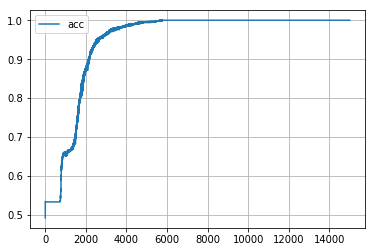

In [13]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [14]:
wrong   = 0
right   = 0

predictedTestLabelList = []
""
for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

# Please input your UBID and personNumber 
testDataInput = testingData['input'].tolist()
testDataLabel = testingData['label'].tolist()

testDataInput.insert(0, "UBID")
testDataLabel.insert(0, "hnitturk")

testDataInput.insert(1, "personNumber")
testDataLabel.insert(1, "50291411")

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabelList

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')

Errors: 6  Correct :94
Testing Accuracy: 94.0
